Computed baseline voltage: 0.01753652869 V


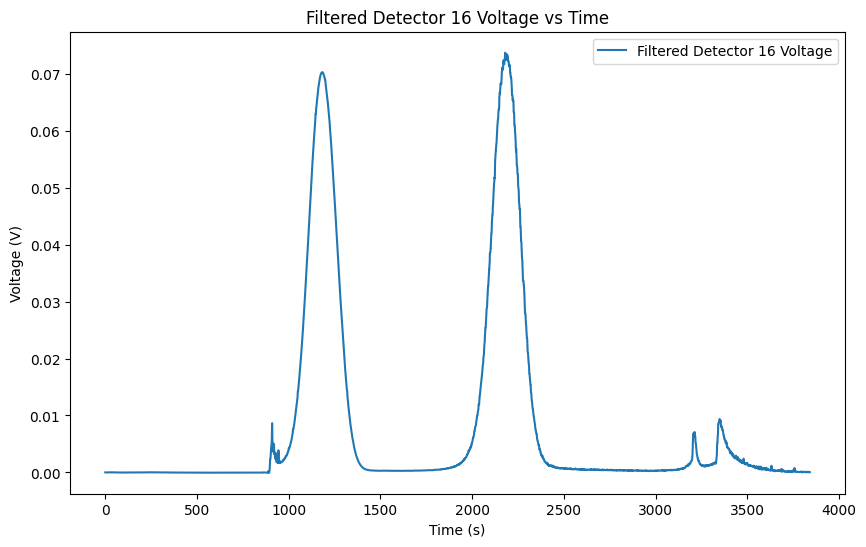

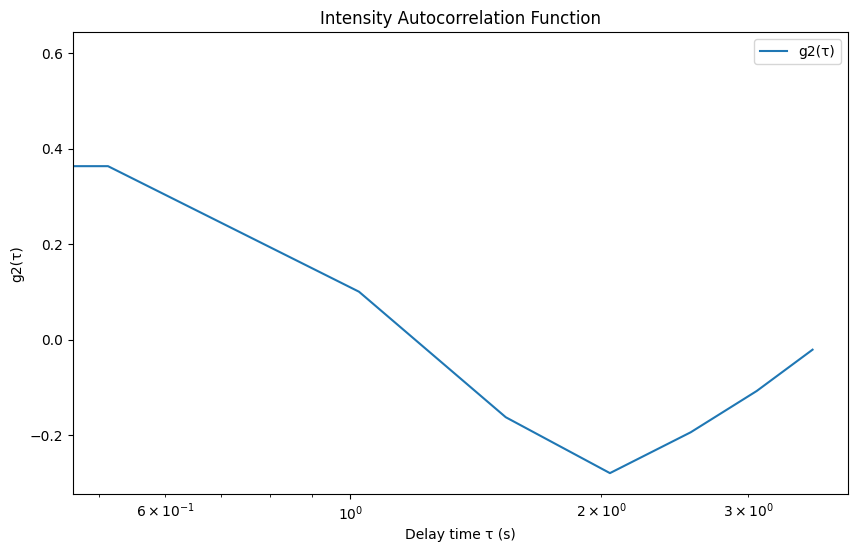

Fitted parameters:
B = -0.17728755121943254
beta = 0.8229989879420844
Gamma = 0.6314637782377639


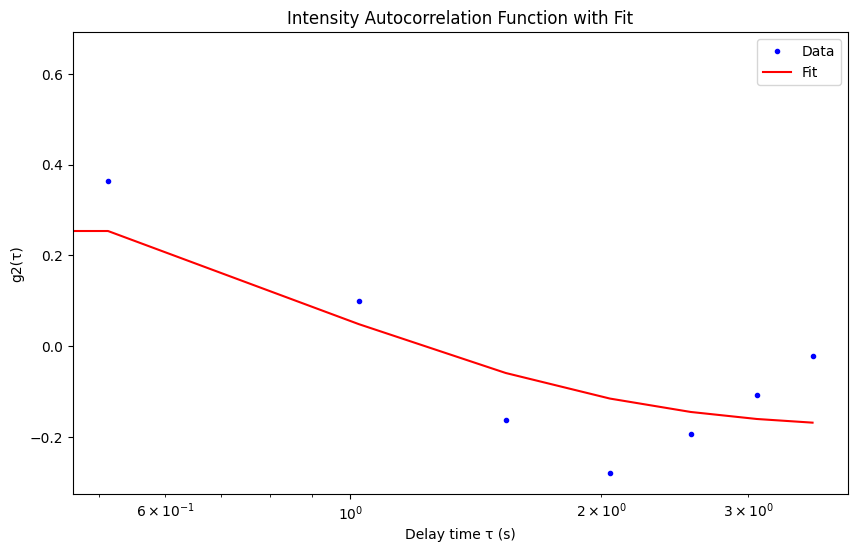

Scattering vector q: 244583.75483580728 cm^-1
Diffusion coefficient D: 1.055585042834074e-11 cm^2/s
Hydrodynamic radius Rh: 220487.8209444531 nm


KeyError: "None of [Index([0], dtype='int64')] are in the [index]"

In [72]:
# Spare Code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.optimize import curve_fit

%matplotlib inline

data = pd.read_csv('747.csv')

time = data['time (min)']  # Time in minutes
detector_16_voltage = data['raw light scattering data: detector voltage  (V) detector 16']

time_sec = time * 60

# Baseline correction and despiking

# Compute the baseline as the mean of the initial data points
baseline_points = 100  # Number of points to consider for baseline
baseline = np.mean(detector_16_voltage[:baseline_points])
print(f'Computed baseline voltage: {baseline} V')

# Minus baseline from detector voltage
detector_16_voltage_baseline_corrected = detector_16_voltage - baseline

# Median Filter
detector_16_voltage_filtered = medfilt(detector_16_voltage_baseline_corrected, kernel_size=5)\

# Plot the filtered data to select time window for peak
plt.figure(figsize=(10, 6))
plt.plot(time_sec, detector_16_voltage_filtered, label='Filtered Detector 16 Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Filtered Detector 16 Voltage vs Time')
plt.legend()
plt.show()

# User inputs time window for the peak
t1 = 34.2316 # float(input('Enter start time for peak (s): '))
t2 = 38.6007 # float(input('Enter end time for peak (s): '))

# Select data within the time window
peak_indices = (time_sec >= t1) & (time_sec <= t2)
time_peak = time_sec[peak_indices]
voltage_peak = detector_16_voltage_filtered[peak_indices]

# Compute g2(tau)
I_mean = np.mean(voltage_peak)
I_fluct = voltage_peak - I_mean

autocorr = np.correlate(I_fluct, I_fluct, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # Take the second half

g2_tau = autocorr / (I_mean**2 * len(voltage_peak))

dt = np.mean(np.diff(time_peak))  # Sampling interval
tau = np.arange(len(g2_tau)) * dt  # Delay times

# Intensity Autocorr Plot
plt.figure(figsize=(10, 6))
plt.semilogx(tau, g2_tau, label='g2(τ)')
plt.xlabel('Delay time τ (s)')
plt.ylabel('g2(τ)')
plt.title('Intensity Autocorrelation Function')
plt.legend()
plt.show()

# Fit to extract decay rate
def g2_model(tau, B, beta, Gamma):
    return B + beta * np.exp(-2 * Gamma * tau)

B_initial = 1.0  # Baseline at infinite delay
beta_initial = g2_tau[0] - B_initial  # Amplitude at zero delay
Gamma_initial = 1.0  # Initial decay rate

p0 = [B_initial, beta_initial, Gamma_initial]

# Perform nonlinear least squares fitting
popt, pcov = curve_fit(g2_model, tau, g2_tau, p0=p0)

# Extract fitted parameters
B_fit, beta_fit, Gamma_fit = popt

print(f'Fitted parameters:\nB = {B_fit}\nbeta = {beta_fit}\nGamma = {Gamma_fit}')

# Plot the fitted curve
g2_fit = g2_model(tau, *popt)

plt.figure(figsize=(10, 6))
plt.semilogx(tau, g2_tau, 'b.', label='Data')
plt.semilogx(tau, g2_fit, 'r-', label='Fit')
plt.xlabel('Delay time τ (s)')
plt.ylabel('g2(τ)')
plt.title('Intensity Autocorrelation Function with Fit')
plt.legend()
plt.show()

# Calculate Scat Vector
# Constants
n = 1.333  # Refractive index of the medium (assuming water)
lambda_nm = 660  # Laser wavelength in nm
lambda_cm = lambda_nm * 1e-7  # Convert wavelength to cm
theta_deg = 149.02  # Scattering angle for Detector 16
theta_rad = np.deg2rad(theta_deg)  # Convert angle to radians

q = (4 * np.pi * n / lambda_cm) * np.sin(theta_rad / 2)
print(f'Scattering vector q: {q} cm^-1')

# Calculate diffusion coefficient D from the decay rate and scat vector
D = Gamma_fit / (q**2)
print(f'Diffusion coefficient D: {D} cm^2/s')


# Calculate Rh
# Constants
k_B = 1.38064852e-16  # Boltzmann constant in erg/K (1 erg = 1e-7 J)
T = 23 + 273.15  # Temperature in Kelvin
eta = 0.932e-2  # Viscosity of water at 23°C in g/(cm·s)

Rh = (k_B * T) / (6 * np.pi * eta * D)

print(f'Hydrodynamic radius Rh: {Rh * 1e7} nm')  # Convert to nm

# Plot Rh over time
N_slices = 10
slice_indices = np.array_split(np.arange(len(time_peak)), N_slices)
Rh_values = []
time_values = []

for indices in slice_indices:
    I_slice = voltage_peak[indices]
    time_slice = time_peak[indices]

    # Compute autocorrelation for the slice
    I_mean = np.mean(I_slice)
    I_fluct = I_slice - I_mean

    autocorr = np.correlate(I_fluct, I_fluct, mode='full')
    autocorr = autocorr[autocorr.size // 2:]

    g2_tau = autocorr / (I_mean**2 * len(I_slice))

    # Delay times τ
    dt = np.mean(np.diff(time_slice))
    tau = np.arange(len(g2_tau)) * dt

    # Fit g2(τ)
    try:
        popt, pcov = curve_fit(g2_model, tau, g2_tau, p0=p0)
        Gamma_fit = popt[2]
        D = Gamma_fit / (q**2)
        Rh = (k_B * T) / (6 * np.pi * eta * D)
        Rh_values.append(Rh * 1e7)  # Convert to nm
        time_values.append(np.mean(time_slice))
    except RuntimeError:
        # Fit did not converge
        Rh_values.append(np.nan)
        time_values.append(np.mean(time_slice))

# Plot Rh over time
plt.figure(figsize=(10, 6))
plt.plot(time_values, Rh_values, 'o-', label='Rh over time')
plt.xlabel('Time (s)')
plt.ylabel('Hydrodynamic Radius Rh (nm)')
plt.title('Hydrodynamic Radius over Time')
plt.legend()
plt.show()

# **Overlay Rh on Intensity Plot**

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Intensity (V)', color=color)
ax1.plot(time_peak, voltage_peak, color=color, label='Intensity')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Hydrodynamic Radius Rh (nm)', color=color)
ax2.plot(time_values, Rh_values, 'o-', color=color, label='Rh')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Intensity and Hydrodynamic Radius over Time')
fig.tight_layout()
plt.show()

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

%matplotlib inline

In [49]:
# Read the data from a CSV file
data = pd.read_csv('747.csv')

# Extract time and Detector 16 voltage data
time = data['time (min)']  # Time in minutes
detector_16_voltage = data['raw light scattering data: detector voltage  (V) detector 16']

# Convert time to seconds
time_sec = time * 60  # Time in seconds

In [50]:
baseline_points = 100  # Number of points to consider for baseline
baseline = np.mean(detector_16_voltage[:baseline_points])
print(f'Computed baseline voltage: {baseline:.4f} V')

# Subtract the baseline from the detector voltage
detector_16_voltage_baseline_corrected = detector_16_voltage - baseline

# Despiking with Median Filter

# Apply median filter to remove spikes from the data
detector_16_voltage_filtered = medfilt(detector_16_voltage_baseline_corrected, kernel_size=5)

Computed baseline voltage: 0.0175 V


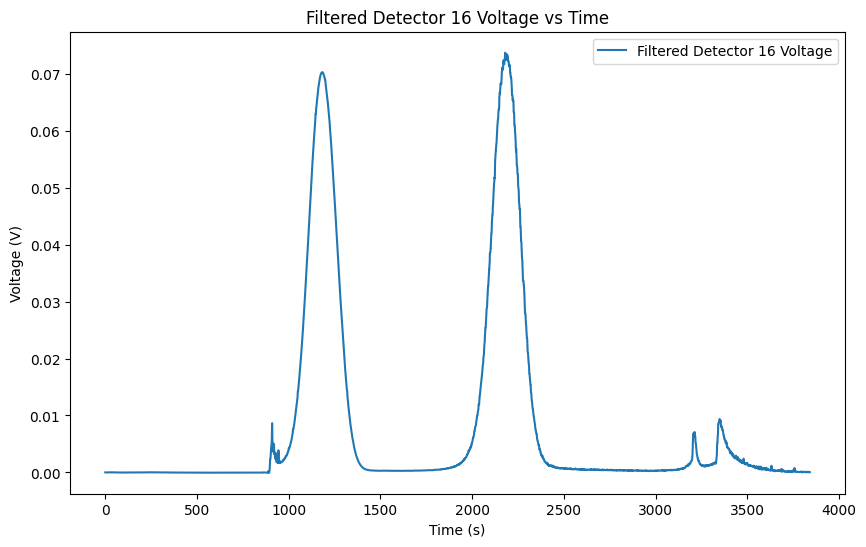

In [51]:
# Select Peak
# Plot the filtered data to select time window for peak
plt.figure(figsize=(10, 6))
plt.plot(time_sec, detector_16_voltage_filtered, label='Filtered Detector 16 Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Filtered Detector 16 Voltage vs Time')
plt.legend()
plt.show()

# User inputs time window for the peak
t1 = float(input('Enter start time for peak (s): '))
t2 = float(input('Enter end time for peak (s): '))

# Select data within the time window
peak_indices = (time_sec >= t1) & (time_sec <= t2)
time_peak = time_sec[peak_indices]
voltage_peak = detector_16_voltage_filtered[peak_indices]


Scattering vector q: 2.45e+05 cm^-1


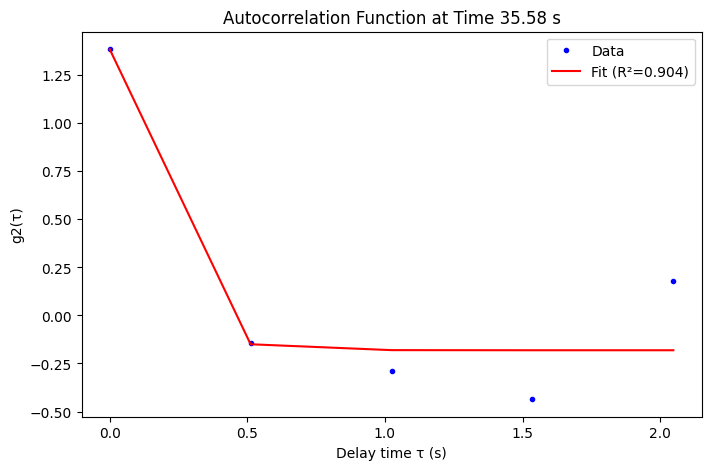

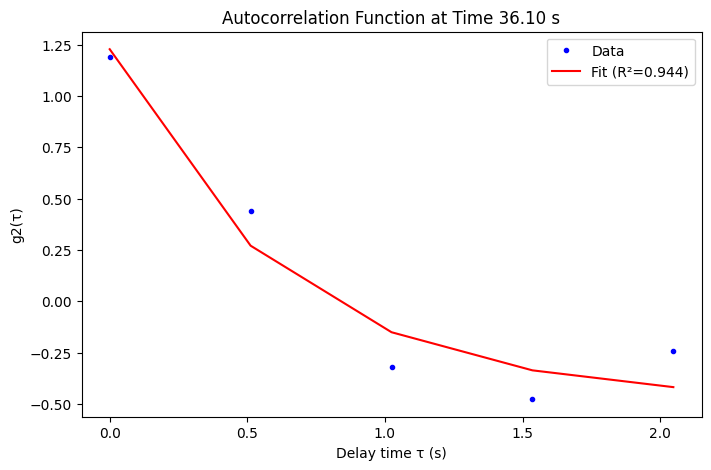

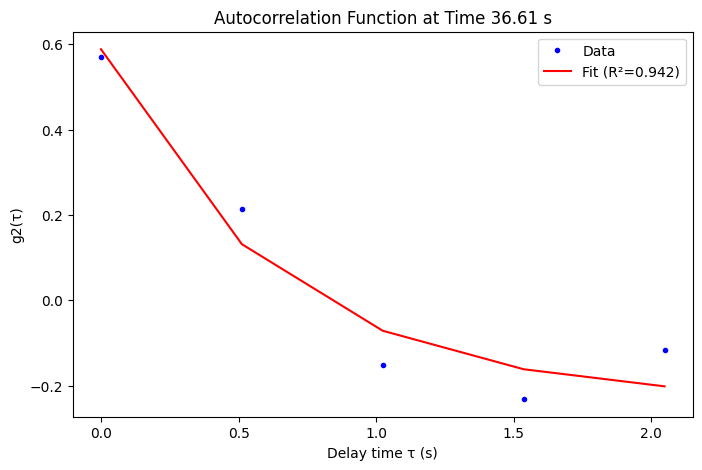

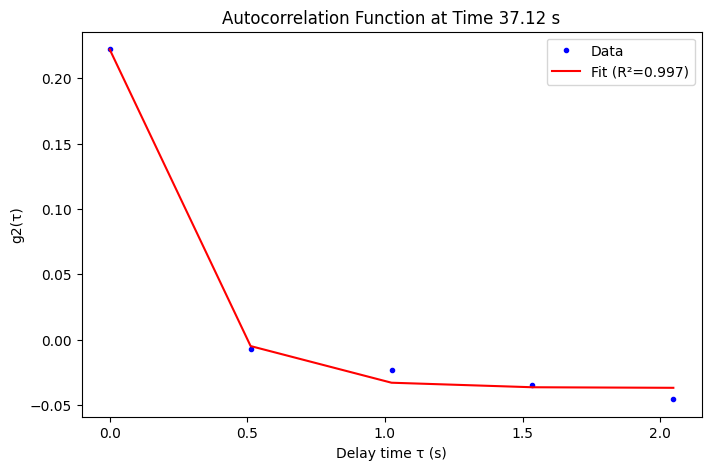

In [68]:
# Corr Function
# Define the model function for fitting
def g2_model(tau, B, beta, Gamma):
    return B + beta * np.exp(-2 * Gamma * tau)

# Constants for calculations
n = 1.333  # Refractive index of the medium (assuming water)
lambda_nm = 660  # Laser wavelength in nm
lambda_cm = lambda_nm * 1e-7  # Convert wavelength to cm
theta_deg = 149.02  # Scattering angle for Detector 16
theta_rad = np.deg2rad(theta_deg)  # Convert angle to radians

# Calculate scattering vector q
q = (4 * np.pi * n / lambda_cm) * np.sin(theta_rad / 2)
print(f'Scattering vector q: {q:.2e} cm^-1')

# Physical constants
k_B = 1.38064852e-16  # Boltzmann constant in erg/K (1 erg = 1e-7 J)
T = 23 + 273.15  # Temperature in Kelvin
eta = 0.932e-2  # Viscosity of water at 23°C in g/(cm·s)

# Parameters for time slices
window_size = 5  # Number of data points in each time slice (adjust as needed)
step_size = 1  # Step size between windows (overlap windows for better resolution)

Rh_values = []
time_values = []
R2_values = []

for start in range(0, len(voltage_peak) - window_size + 1, step_size):
    # Extract data for the current time slice
    I_slice = voltage_peak[start:start+window_size]
    time_slice = time_peak[start:start+window_size]
    
    # Compute the mean intensity
    I_mean = np.mean(I_slice)
    
    # Compute intensity fluctuations
    I_fluct = I_slice - I_mean
    
    # Compute autocorrelation function
    autocorr = np.correlate(I_fluct, I_fluct, mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Take the second half
    
    # Normalize to get g2(τ)
    g2_tau = autocorr / (I_mean**2 * len(I_slice))
    
    # Calculate delay times τ
    dt = np.mean(np.diff(time_slice))  # Sampling interval
    tau = np.arange(len(g2_tau)) * dt  # Delay times
    
    # Fit g2(τ) to extract decay rate Γ
    # Use only the first part of g2_tau where data is significant
    max_lag = 50  # Adjust max lag time as needed
    tau_fit = tau[:max_lag]
    g2_tau_fit = g2_tau[:max_lag]
    
    # Initial guesses for fitting parameters
    B_initial = 1.0
    beta_initial = g2_tau_fit[0] - B_initial
    Gamma_initial = 1.0
    
    p0 = [B_initial, beta_initial, Gamma_initial]
    
    # Perform nonlinear least squares fitting
    try:
        popt, pcov = curve_fit(g2_model, tau_fit, g2_tau_fit, p0=p0)
        B_fit, beta_fit, Gamma_fit = popt
        
        # Calculate fitted g2
        g2_fit = g2_model(tau_fit, *popt)
        
        # Calculate R² value
        residuals = g2_tau_fit - g2_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((g2_tau_fit - np.mean(g2_tau_fit))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Calculate diffusion coefficient D
        D = Gamma_fit / (q**2)
        
        # Calculate hydrodynamic radius Rh
        Rh = (k_B * T) / (6 * np.pi * eta * D)
        
        # Store results
        Rh_values.append(Rh * 1e7)  # Convert to nm
        time_values.append(np.mean(time_slice))
        R2_values.append(r_squared)
        
        # Plot g2(τ) and the fit
        plt.figure(figsize=(8, 5))
        plt.plot(tau_fit, g2_tau_fit, 'b.', label='Data')
        plt.plot(tau_fit, g2_fit, 'r-', label=f'Fit (R²={r_squared:.3f})')
        plt.xlabel('Delay time τ (s)')
        plt.ylabel('g2(τ)')
        plt.title(f'Autocorrelation Function at Time {np.mean(time_slice):.2f} s')
        plt.legend()
        plt.show()
        
    except RuntimeError:
        # Fit did not converge
        Rh_values.append(np.nan)
        time_values.append(np.mean(time_slice))
        R2_values.append(np.nan)
        print(f'Fit did not converge at time {np.mean(time_slice):.2f} s')


In [69]:
# Average Rh
# Calculate the overall average Rh value
Rh_array = np.array(Rh_values)
valid_Rh = Rh_array[~np.isnan(Rh_array)]
average_Rh = np.mean(valid_Rh)

print(f'Overall average Hydrodynamic radius Rh: {average_Rh:.2f} nm')


Overall average Hydrodynamic radius Rh: 113540.67 nm


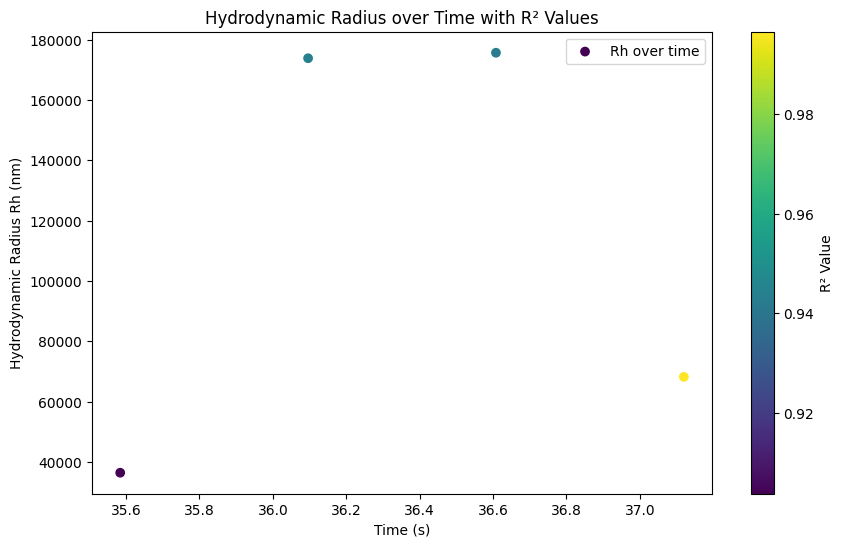

In [70]:
# Plot Rh over time with R² values

plt.figure(figsize=(10, 6))
plt.scatter(time_values, Rh_values, c=R2_values, cmap='viridis', label='Rh over time')
plt.colorbar(label='R² Value')
plt.xlabel('Time (s)')
plt.ylabel('Hydrodynamic Radius Rh (nm)')
plt.title('Hydrodynamic Radius over Time with R² Values')
plt.legend()
plt.show()


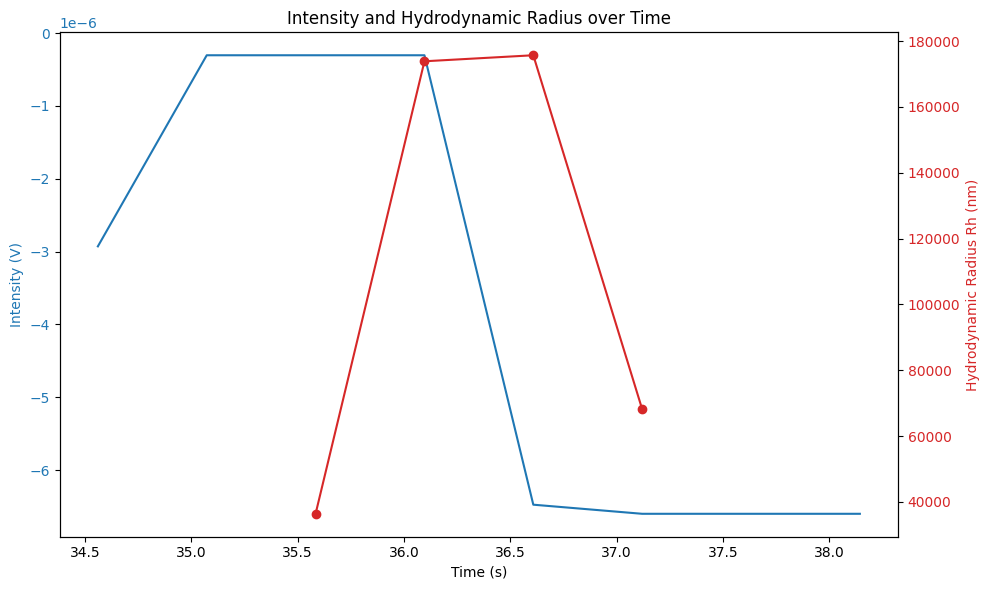

In [71]:
# Plot Intensity and Rh over time

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Intensity (V)', color=color)
ax1.plot(time_peak, voltage_peak, color=color, label='Intensity')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Hydrodynamic Radius Rh (nm)', color=color)
ax2.plot(time_values, Rh_values, 'o-', color=color, label='Rh')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Intensity and Hydrodynamic Radius over Time')
fig.tight_layout()
plt.show()
